In [116]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [278]:
import tensorflow as tf

class PINN(tf.keras.Model):
    def __init__(self, N):
        super().__init__()
        self.N = N
        self.pool = tf.keras.layers.GlobalAveragePooling1D()

        self.sigma_net = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(N, activation='softplus')
        ])

        self.L_net = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(128, activation='swish'),
            tf.keras.layers.Dense(N * (N + 1) // 2)
        ])

    def call(self, x):
        x_pooled = self.pool(x)  # (batch, N)
        sigma = self.sigma_net(x_pooled)  # (batch, N)
        L_flat = self.L_net(x_pooled)     # (batch, N*(N+1)//2)
        rho = self.build_correlation_matrix(L_flat)
        return sigma, rho

    def build_correlation_matrix(self, L_flat):
        batch_size = tf.shape(L_flat)[0]
        tril_indices = np.tril_indices(self.N)
        num_tril = len(tril_indices[0])

        # Préparer les indices (batch, i, j)
        batch_idx = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]
        batch_idx = tf.tile(batch_idx, [1, num_tril])

        i_idx = tf.constant(tril_indices[0], dtype=tf.int32)[tf.newaxis, :]
        j_idx = tf.constant(tril_indices[1], dtype=tf.int32)[tf.newaxis, :]
        i_idx = tf.tile(i_idx, [batch_size, 1])
        j_idx = tf.tile(j_idx, [batch_size, 1])

        full_indices = tf.stack([batch_idx, i_idx, j_idx], axis=-1)
        full_indices = tf.reshape(full_indices, [-1, 3])

        # Appliquer softplus uniquement sur les éléments diagonaux
        L_updates = tf.reshape(L_flat, [batch_size, num_tril])
        L_processed = []

        k = 0
        for i in range(self.N):
            for j in range(i + 1):
                entry = L_updates[:, k]
                if i == j:
                    entry = tf.nn.softplus(entry) + 1e-3  # rendre la diagonale positive
                L_processed.append(entry)
                k += 1

        L_processed = tf.stack(L_processed, axis=1)
        L_processed = tf.reshape(L_processed, [-1])

        L = tf.zeros((batch_size, self.N, self.N), dtype=tf.float32)
        L = tf.tensor_scatter_nd_update(L, full_indices, L_processed)

        rho = tf.matmul(L, L, transpose_b=True)

        # Normaliser pour avoir des corrélations (entre -1 et 1)
        diag = tf.linalg.diag_part(rho)
        diag_inv_sqrt = tf.linalg.diag(1.0 / tf.sqrt(diag + 1e-6))
        rho_corr = tf.matmul(tf.matmul(diag_inv_sqrt, rho), diag_inv_sqrt)

        return rho_corr
    
    # Drift du LMM
    def lmm_drift(L, sigma, delta, rho):
        # L: (batch, T, N), sigma: (batch, N), rho: (batch, N, N), delta: (N,)
        N = tf.shape(L)[-1]

        # Reshape et broadcast des tenseurs pour calcul vectorisé
        sigma_i = tf.expand_dims(sigma, 1)            # (batch, 1, N)
        sigma_j = tf.expand_dims(sigma, 2)            # (batch, N, 1)
        rho_ = tf.expand_dims(rho, 1)                 # (batch, 1, N, N)
        delta_j = tf.reshape(delta, (1, 1, 1, N))      # (1, 1, 1, N)

        L_j = tf.expand_dims(L, 3)                    # (batch, T, N, 1)
        denom = 1.0 + delta_j * L_j                   # (batch, T, N, N)

        term = (delta_j * L_j * sigma_i[..., :, None] * sigma_j[..., None, :] * rho_) / denom  # (batch, T, N, N)

        # Masquer les termes j ≤ i (triangle supérieur strict)
        mask = tf.linalg.band_part(tf.ones((N, N)), -1, 0) - tf.linalg.band_part(tf.ones((N, N)), 0, 0)
        mask = tf.reshape(mask, (1, 1, N, N))  # (1, 1, N, N)

        drift = tf.reduce_sum(term * mask, axis=-1)  # (batch, T, N)
        return drift


In [144]:
# ============== Génération de nouveaux scénarios avec LMM ==============
def simulate_lmm_paths(L0, sigma, delta, rho, n_steps, dt):
    """
    L0: shape (batch, N)
    sigma: shape (batch, N)
    delta: shape (N,)
    rho: shape (batch, N, N)
    """
    batch_size, N = L0.shape
    L = [L0]
 
    rho += tf.eye(N)[None, :, :] * 1e-4  # broadcast sur le batch
    chol = tf.linalg.cholesky(rho)

    for t in range(n_steps):
        Lt = L[-1]
        drift = []
        for i in range(N):
            sum_term = tf.zeros((batch_size,), dtype=Lt.dtype)
            for j in range(i+1, N):
                denom = 1 + delta[j] * Lt[:, j]
                term = delta[j] * Lt[:, j] * sigma[:, i] * sigma[:, j] * rho[:, i, j] / denom
                sum_term += term
            drift.append(sum_term)
        drift = tf.stack(drift, axis=1)  # shape (batch, N)

 
        dW = tf.random.normal((batch_size, N))
        dW_exp = tf.expand_dims(dW, -1)  # (batch, N, 1)
        correlated_noise = tf.matmul(chol, dW_exp)  # (batch, N, 1)
        correlated_noise = tf.squeeze(correlated_noise, -1)  # (batch, N)

 
        dL = drift * dt + sigma * correlated_noise * tf.sqrt(dt)
        L_next = Lt + dL
        L.append(L_next)
 
    return tf.stack(L, axis=1)  # shape (batch, n_steps+1, N)

In [119]:
#importation données
data3000=pd.read_csv("EUR_4Q24_EUR_3000.csv",sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')

In [267]:
#On va reshaper les données d'entrée pour l'entrainement
spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data3000[spot_cols].values  # shape (123000, 40)
Xtrain = spot_data.reshape((3000, 41, 40))  # 3000 scénarios, 41 time_steps, 40 maturités

#Xtrain = Xtrain[:1000]  # shape devient (1500, 41, 40)


Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)
mean = tf.reduce_mean(Xtrain)
std = tf.math.reduce_std(Xtrain)
Xtrain = (Xtrain - mean) / std


In [272]:
# Calcul des rendements logarithmiques
log_returns = tf.math.log(Xtrain[:, 1:, :] / Xtrain[:, :-1, :])  # shape (3000, 40, 40)

# sigma empirique : std sur (batch, time)
sigma_empirical = tf.math.reduce_std(log_returns, axis=[0, 1])  # shape (40,)

# rho empirique : corrélation des rendements aplatis
flat_returns = tf.reshape(log_returns, [-1, N])  # shape (3000*40, 40)
mean_returns = tf.reduce_mean(flat_returns, axis=0, keepdims=True)
centered = flat_returns - mean_returns
cov = tf.matmul(centered, centered, transpose_a=True) / tf.cast(tf.shape(flat_returns)[0] - 1, tf.float32)
stddevs = tf.math.reduce_std(flat_returns, axis=0)
rho_empirical = cov / (tf.expand_dims(stddevs, 0) * tf.expand_dims(stddevs, 1))

In [145]:
# Simulation LMM de test avec les valeurs empiriques
L0 = Xtrain[:, 0, :] * std + mean  # revenir aux vraies valeurs si nécessaire

# Optionnel : prendre un sous-échantillon si trop gros
L0_test = L0[:10]  # par exemple 10 scénarios pour tester

sim_paths = simulate_lmm_paths(
    L0=L0_test,
    sigma=tf.broadcast_to(sigma_empirical, L0_test.shape),  # shape (10, 40)
    delta=delta,
    rho=tf.broadcast_to(rho_empirical, [L0_test.shape[0], N, N]),
    n_steps=40,
    dt=0.25
)

In [295]:
#Entraînement du PINN
N = 40
delta = np.full(N,0.25)
 
pinn_model = PINN(N)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=20,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule)

#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
 

In [297]:
best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(150):
    with tf.GradientTape() as tape:
        sigma_pred, rho_pred = pinn_model(Xtrain[:, :-1, :])
        dL_dt = Xtrain[:, 1:, :] - Xtrain[:, :-1, :]
        dL_mean = tf.reduce_mean(dL_dt)
        dL_std = tf.math.reduce_std(dL_dt)

        dL_dt_norm = (dL_dt - dL_mean) / dL_std
        drift_pred = lmm_drift(Xtrain[:, :-1, :], sigma_pred, delta, rho_pred)
        drift_pred_norm = (drift_pred - dL_mean) / dL_std

        loss = tf.reduce_mean(tf.square(dL_dt_norm - drift_pred_norm))

    grads = tape.gradient(loss, pinn_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn_model.trainable_variables))

    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.6f}")

    # Early stopping
    if loss.numpy() + 1e-5 < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, Loss: 15.180157
Epoch 2, Loss: 8.906554
Epoch 3, Loss: 6.119396
Epoch 4, Loss: 4.210141
Epoch 5, Loss: 3.114988
Epoch 6, Loss: 2.503704
Epoch 7, Loss: 2.116270
Epoch 8, Loss: 1.842252
Epoch 9, Loss: 1.640059
Epoch 10, Loss: 1.489516
Epoch 11, Loss: 1.377491
Epoch 12, Loss: 1.294260
Epoch 13, Loss: 1.232385
Epoch 14, Loss: 1.186172
Epoch 15, Loss: 1.151323
Epoch 16, Loss: 1.124673
Epoch 17, Loss: 1.103964
Epoch 18, Loss: 1.087650
Epoch 19, Loss: 1.074690
Epoch 20, Loss: 1.064346
Epoch 21, Loss: 1.057560
Epoch 22, Loss: 1.051805
Epoch 23, Loss: 1.046875
Epoch 24, Loss: 1.042628
Epoch 25, Loss: 1.038962
Epoch 26, Loss: 1.035787
Epoch 27, Loss: 1.033016
Epoch 28, Loss: 1.030568
Epoch 29, Loss: 1.028383
Epoch 30, Loss: 1.026415
Epoch 31, Loss: 1.024627
Epoch 32, Loss: 1.022984
Epoch 33, Loss: 1.021461
Epoch 34, Loss: 1.020051
Epoch 35, Loss: 1.018756
Epoch 36, Loss: 1.017577
Epoch 37, Loss: 1.016508
Epoch 38, Loss: 1.015538
Epoch 39, Loss: 1.014655
Epoch 40, Loss: 1.013850
Epoch 41

In [298]:
# Exemple : Générer 1000 nouvelles trajectoires
sigma_final, rho_final = pinn_model(Xtrain[:, :-1, :])
sigma_final = sigma_final[:1000]
rho_final = rho_final[:1000]
L0 = Xtrain[:1000, 0, :]  # première valeur de chaque trajectoire
 
generated_paths = simulate_lmm_paths(L0, sigma_final, delta, rho_final, n_steps=40, dt=0.5)

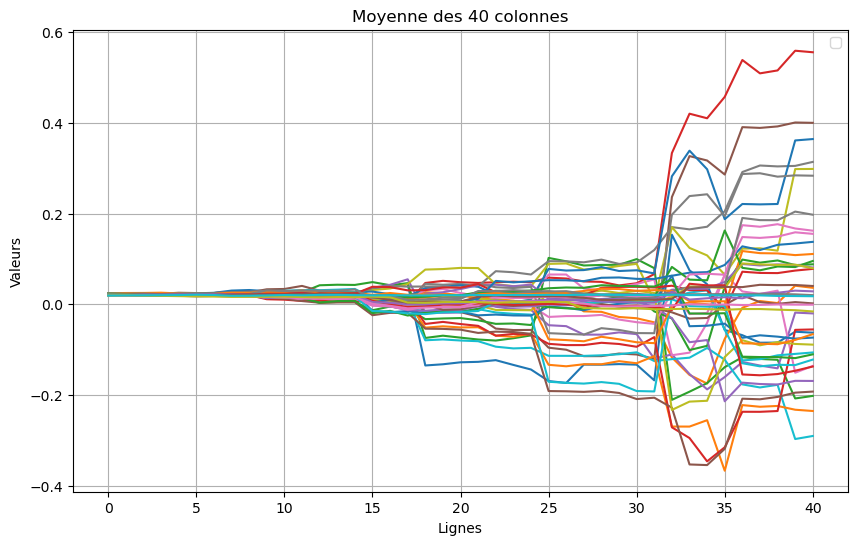

In [299]:
generated_paths_unscaled = generated_paths * std + mean
mean_paths = np.mean(generated_paths_unscaled, axis=0)
import matplotlib.pyplot as plt

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()
